In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM , Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import save_model


In [2]:
#loading data
data = pd.read_csv("/Users/samenergy/Documents/Projects/sentiment/IMDB Dataset.csv")
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [4]:
data["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [5]:
# word count in the review
def words_in_review(text):
  word_list = text.split()
  return len(word_list)

data['num_words'] = data['review'].apply(words_in_review)
data.head()

,review,sentiment,num_words
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


In [6]:
#printing the shape of the data
data.shape

(50000, 3)

In [7]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samenergy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/samenergy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/samenergy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
#stop words in the dataset
from nltk.corpus import stopwords
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [9]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [10]:
#checking for missing values
data.isna().sum()

review       0
sentiment    0
num_words    0
dtype: int64

In [11]:
#checking the statistical properties of data
data.describe()

,num_words
count,50000.000000
mean,231.156940
std,171.343997
min,4.000000
25%,126.000000
50%,173.000000
75%,280.000000
max,2470.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
 2   num_words  50000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


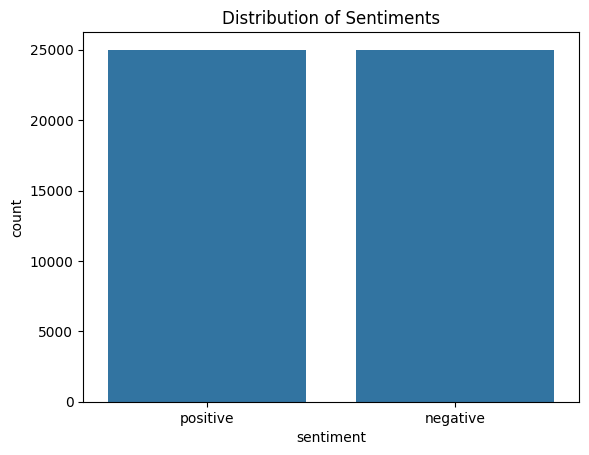

In [13]:
#plotting a count to check the distribution of sentiment class
sns.countplot(x='sentiment', data=data)
plt.title('Distribution of Sentiments')
plt.show()

From the Above count plot, we can see that the sentiments has equal class distribution of *25000* and this will help reduce bias of model during predictions.

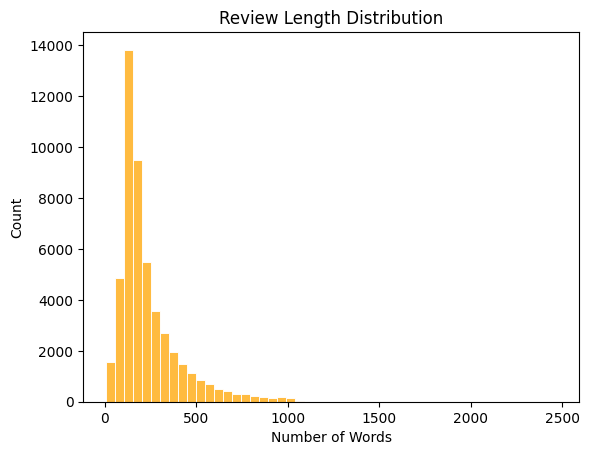

In [14]:
#Histogram to visualize review length distribution; that is short and long reviews.
sns.histplot(data['num_words'], bins=50, color ="Orange", edgecolor='white')
plt.title('Review Length Distribution')
plt.xlabel('Number of Words')
plt.show()


From the histogram, the number of words for each review is typically between 100 to 1000. It does extend beyond that. which makes sense for a typical IMDB reviews.

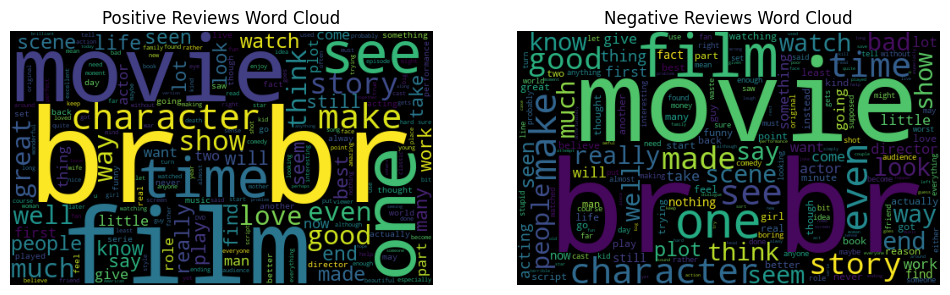

In [15]:
#word cloud for most frequent words

#filters only positive reviews
positive_text = " ".join(data[data['sentiment'] == 'positive']['review'])
#filters only positive reviews
negative_text = " ".join(data[data['sentiment'] == 'negative']['review'])

#plot for positive reviews
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=500, height=300).generate(positive_text))
plt.title("Positive Reviews Word Cloud")
plt.axis("off")

#plot for negative reviews
plt.subplot(1,2,2)
plt.imshow(WordCloud(width=500, height=300).generate(negative_text))
plt.title("Negative Reviews Word Cloud")
plt.axis("off")
plt.show()


from these plots, we can see that words lie **film, movie, one, show ,time** appear often.
You can also see "br" appearing most often, that is because the data hasn't been cleaned to remove the tags since data was scraped.

# DATA PREPARATION

In [16]:
#removal of HTML tags using
data['review'] = data['review'].apply(lambda x: re.sub(r'<[^>]+>', '', x))


In [17]:
data["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [18]:
#removing punctuations, URLs and special characters
data['review'] = data['review'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [19]:
data['review'][3]

'Basically theres a family where a little boy Jake thinks theres a zombie in his closet  his parents are fighting all the timeThis movie is slower than a soap opera and suddenly Jake decides to become Rambo and kill the zombieOK first of all when youre going to make a film you must Decide if its a thriller or a drama As a drama the movie is watchable Parents are divorcing  arguing like in real life And then we have Jake with his closet which totally ruins all the film I expected to see a BOOGEYMAN similar movie and instead i watched a drama with some meaningless thriller spots3 out of 10 just for the well playing parents  descent dialogs As for the shots with Jake just ignore them'

In [20]:
data['review'][10]

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlinesAt first it was very odd and pretty funny but as the movie progressed I didnt find the jokes or oddness funny anymoreIts a low budget film thats never a problem in itself there were some pretty interesting characters but eventually I just lost interestI imagine this film would appeal to a stoner who is currently partakingFor something similar but better try Brother from another planet'

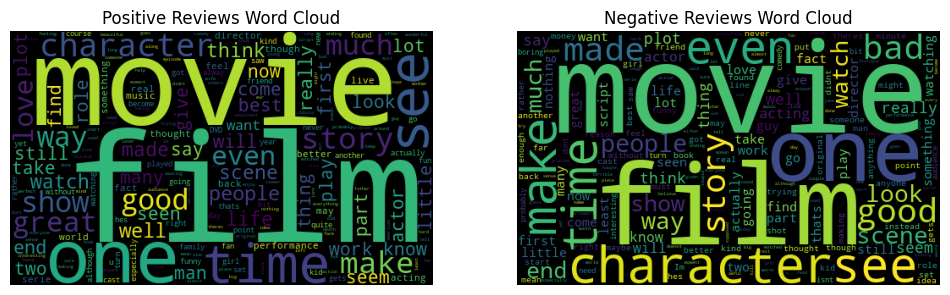

In [21]:
#word cloud for most frequent words

#filters only positive reviews
positive_text = " ".join(data[data['sentiment'] == 'positive']['review'])
#filters only positive reviews
negative_text = " ".join(data[data['sentiment'] == 'negative']['review'])

#plot for positive reviews
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=500, height=300).generate(positive_text))
plt.title("Positive Reviews Word Cloud")
plt.axis("off")

#plot for negative reviews
plt.subplot(1,2,2)
plt.imshow(WordCloud(width=500, height=300).generate(negative_text))
plt.title("Negative Reviews Word Cloud")
plt.axis("off")
plt.show()


Plotting the word cloud again after cleaning, there is no longer "br" showing.

In [22]:
# Converting sentiments to binary
data['sentiment'] = data['sentiment'].replace({"positive": 1, "negative": 0})


/var/folders/nw/4wgt1dcd6bj1ffvdxws4b8v40000gn/T/ipykernel_89470/2798616217.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['sentiment'] = data['sentiment'].replace({"positive": 1, "negative": 0})


# TOKENIZATION

In [23]:
data['review']= data['review'].apply(word_tokenize)

In [24]:
data['review'][5]

['Probably',
 'my',
 'alltime',
 'favorite',
 'movie',
 'a',
 'story',
 'of',
 'selflessness',
 'sacrifice',
 'and',
 'dedication',
 'to',
 'a',
 'noble',
 'cause',
 'but',
 'its',
 'not',
 'preachy',
 'or',
 'boring',
 'It',
 'just',
 'never',
 'gets',
 'old',
 'despite',
 'my',
 'having',
 'seen',
 'it',
 'some',
 '15',
 'or',
 'more',
 'times',
 'in',
 'the',
 'last',
 '25',
 'years',
 'Paul',
 'Lukas',
 'performance',
 'brings',
 'tears',
 'to',
 'my',
 'eyes',
 'and',
 'Bette',
 'Davis',
 'in',
 'one',
 'of',
 'her',
 'very',
 'few',
 'truly',
 'sympathetic',
 'roles',
 'is',
 'a',
 'delight',
 'The',
 'kids',
 'are',
 'as',
 'grandma',
 'says',
 'more',
 'like',
 'dressedup',
 'midgets',
 'than',
 'children',
 'but',
 'that',
 'only',
 'makes',
 'them',
 'more',
 'fun',
 'to',
 'watch',
 'And',
 'the',
 'mothers',
 'slow',
 'awakening',
 'to',
 'whats',
 'happening',
 'in',
 'the',
 'world',
 'and',
 'under',
 'her',
 'own',
 'roof',
 'is',
 'believable',
 'and',
 'startling',
 '

In [25]:
#removing stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['review'] = data['review'].apply(lambda x: [word for word in x if word not in stop_words])

In [26]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samenergy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
"""
reducing words to its base form
using Lemmatization to ensure that word doesn't loose
it's dictionary roots as compared to
stemming which doesn't look at the meaning or dictionary roots.
stemming can be inaccurate sometimes so it's safe to use Lemmatization.
 pos: "v means only verbs should be lemmatized

"""
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
data['review'] = data['review'].apply(lambda x: [lemmatizer.lemmatize(word, pos='v') for word in x])

In [28]:
# #Tokenising reviews
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(data['review'])
# X_sequence = tokenizer.texts_to_sequences(data['review'])

# # Padding the sequences for uniform length
# X_padding = pad_sequences(X_sequence, maxlen=300)
# print(X_padding.shape)

In [29]:
# split data into training data and test data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [30]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["review"])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

In [31]:
print(X_train)

[[   0    0    0 ...  140   54 3335]
 [   0    0    0 ...  136   36   13]
 [   0    0    0 ...  235  208   21]
 ...
 [   0    0    0 ... 1037  324  570]
 [   0    0    0 ... 1157  183   13]
 [   0    0    0 ...  429   25 1763]]


In [32]:
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

In [33]:
print(Y_train)

39087    0
30893    0
45278    1
16398    0
13653    0
        ..
11284    1
44732    1
38158    0
860      1
15795    1
Name: sentiment, Length: 40000, dtype: int64


# Deep Learning Model

In [34]:
# build the model
model = Sequential()
model.add(Input(shape=(200,)))
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model.add(Dense(1, activation="sigmoid"))


# Now summary will show proper shapes and parameters
model.summary()

/Users/samenergy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,105 (3.14 MB)

 Trainable params: 823,105 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# compile the model
model.compile(optimizer="Nadam", loss="binary_crossentropy", metrics=["accuracy"])

In [36]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [37]:
# Train the model with Early Stopping
history = model.fit(X_train, Y_train, epochs=20, batch_size= 64, validation_split=0.2,  callbacks=[early_stopping])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 174ms/step - accuracy: 0.7768 - loss: 0.5443 - val_accuracy: 0.8830 - val_loss: 0.2977
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 179ms/step - accuracy: 0.9050 - loss: 0.2447 - val_accuracy: 0.8749 - val_loss: 0.2914
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - accuracy: 0.9285 - loss: 0.1959 - val_accuracy: 0.8794 - val_loss: 0.3156
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - accuracy: 0.9442 - loss: 0.1594 - val_accuracy: 0.8748 - val_loss: 0.3526
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 170ms/step - accuracy: 0.9583 - loss: 0.1314 - val_accuracy: 0.8748 - val_loss: 0.3850


Test Accuracy: 0.8818
Test Loss: 0.2816804051399231
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
Precision: 0.8949
Recall: 0.8672
F1 Score: 0.8809
Confusion Matrix:
[[4448  513]
 [ 669 4370]]


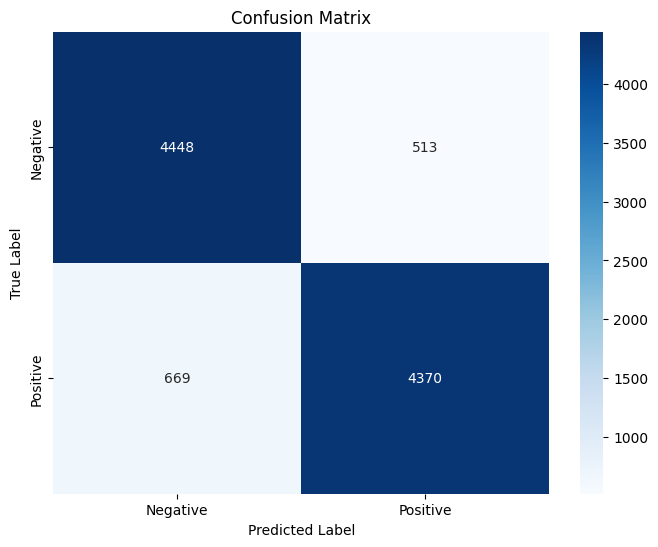

In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')
print(f"Test Loss: {loss}")

# Get predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate metrics
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

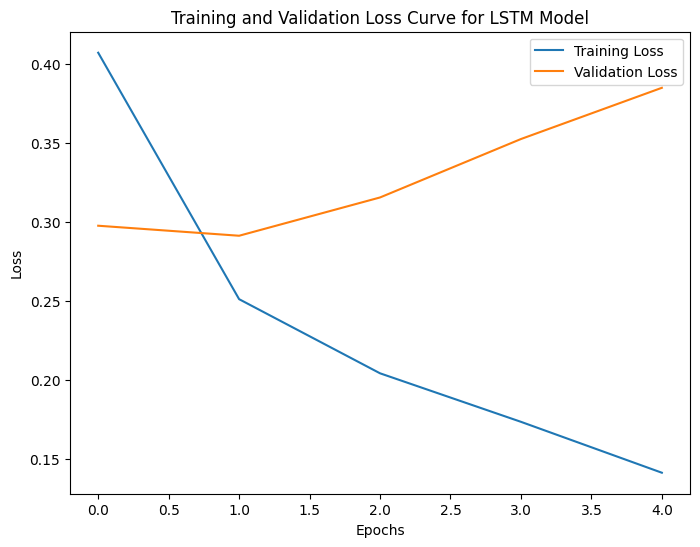

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve for LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Building a Predictive System**

In [41]:
model.save(f'model_Nadam.keras')

In [42]:
def predict_sentiment(review):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

In [43]:
# example usage
new_review = "The released season for Good Doctors.Was awesome it."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The sentiment of the review is: positive


In [44]:
# example usage
new_review = "The avenger movie was not that good"
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The sentiment of the review is: negative


In [45]:
# example usage
new_review = "This movie was ok but not that good."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The sentiment of the review is: negative


# Traditional ML Model: Logistic Regression

In [ ]:
# Re-join tokens for TF-IDF
#data['processed_text'] = data['reviews'].apply(lambda x: " ".join(x))

#tfidf = TfidfVectorizer(max_features=5000)
#X_tfidf = tfidf.fit_transform(data['processed_text'])

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, Y_train)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate and assign metrics for Logistic Regression
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
conf_matrix_lr = confusion_matrix(Y_test, y_pred) # Also calculate confusion matrix here

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values,)
plt.ylim(0, 1.1) # Set y-axis limit between 0 and 1.1
plt.title('Performance Metrics for Logistic Regression Model')
plt.ylabel('Score')
plt.show()

In [ ]:
# Visualize the confusion matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Traditional ML Model: Naïve Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, Y_train)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred_nb = nb_model.predict(X_test)

# Calculate metrics for Naive Bayes
accuracy_nb = accuracy_score(Y_test, y_pred_nb)
precision_nb = precision_score(Y_test, y_pred_nb)
recall_nb = recall_score(Y_test, y_pred_nb)
f1_nb = f1_score(Y_test, y_pred_nb)

print("Accuracy:", accuracy_nb)
print("Precision:", precision_nb)
print("Recall:", recall_nb)
print("F1 Score:", f1_nb)

In [ ]:
#bar graph for Naive Bayes metrics
metrics_nb = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values_nb = [accuracy_nb, precision_nb, recall_nb, f1_nb]

plt.figure(figsize=(8, 6))
plt.bar(metrics_nb, values_nb)
plt.ylim(0, 1.1) # Set y-axis limit between 0 and 1.1
plt.title('Performance Metrics for Naive Bayes Model')
plt.ylabel('Score')
plt.show()


In [ ]:
# Confusion Matrix for Sklearn Naive Bayes
cm = confusion_matrix(Y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Sklearn Naive Bayes Confusion Matrix")
plt.show()